### Setting up the environment:

In [58]:
import cv2
import os
import tensorflow as tf
import numpy as np
import imageio
import gdown
import dlib
from typing import List
from matplotlib import pyplot as plt

In [59]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

### Preprocessing:
I am using the following excerpt from the paper as a reference to preprocess the data:

All videos are 3 seconds long with a frame rate of 25fps. The videos were processed with the DLib face detector, and the iBug face landmark predictor (Sagonas et al., 2013) with 68 landmarks coupled with an online Kalman Filter. Using these landmarks, we apply an affine transformation to extract a mouth-centred crop of size 100 × 50 pixels per frame. We standardise the RGB channels over the whole training set to have zero mean and unit variance.

In [60]:
hog_face_detector = dlib.get_frontal_face_detector()
dlib_facelandmark = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

def preprocess_video(path: str) -> List[np.ndarray]:
    cap = cv2.VideoCapture(path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = hog_face_detector(frame)
        if len(faces) == 0:
            continue
        face = faces[0]
        landmarks = dlib_facelandmark(frame, face)
        if landmarks:
            mouth_points = np.array([[p.x, p.y] for p in landmarks.parts()[48:68]])
            x, y, w, h = cv2.boundingRect(mouth_points)
            if w > 0 and h > 0:  # Check if bounding box is valid
                mouth = frame[y:y+h, x:x+w]
                mouth_resized = cv2.resize(mouth, (100, 50))
                frames.append(mouth_resized)
            else:
                continue
        else:
            continue
    cap.release()

    if len(frames) > 0:
        # Convert list to numpy array for standardization
        frames_np = np.stack(frames)
        # Standardize the frames
        mean = np.mean(frames_np, axis=0)
        std = np.std(frames_np, axis=0)
        frames_standardized = (frames_np - mean) / std
        return frames_standardized.tolist()
    else:
        return []  # Return an empty list if no frames processed

### Creating a vocabulary:

In [61]:
vocab = [l for l in "abcdefghijklmnopqrstuvwxyz'!?1234567890 "]

In [62]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=list(vocab), 
                                           oov_token='',)
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), 
    oov_token='', 
    invert=True)

print(
    f"The vocabulary contains: {char_to_num.get_vocabulary()}, \n"
    f"And the size of the vocabulary is {char_to_num.vocabulary_size()}"
)

The vocabulary contains: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '!', '?', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', ' '], 
And the size of the vocabulary is 41


### Load in data:

In [63]:
test_path = '.\\data\\s1\\swwc4n.mpg'

In [64]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [65]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = preprocess_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [66]:
#tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

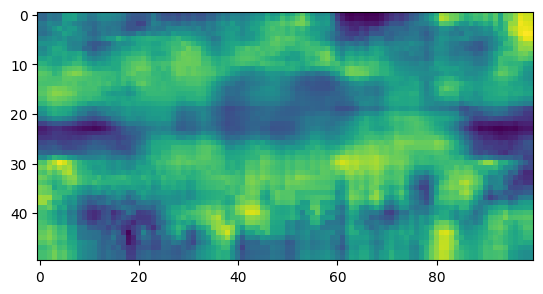

tf.Tensor(b'set white with c four now', shape=(), dtype=string)


In [67]:
# We can clearly see the lips in the middle
frames, alignments = load_data(tf.convert_to_tensor(test_path))
plt.imshow(frames[74])
plt.show()
print(tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()]))

In [68]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

### Setting up the data pipeline: